In [1]:
print('hello world')

hello world


# Context Encoder

### Encoder

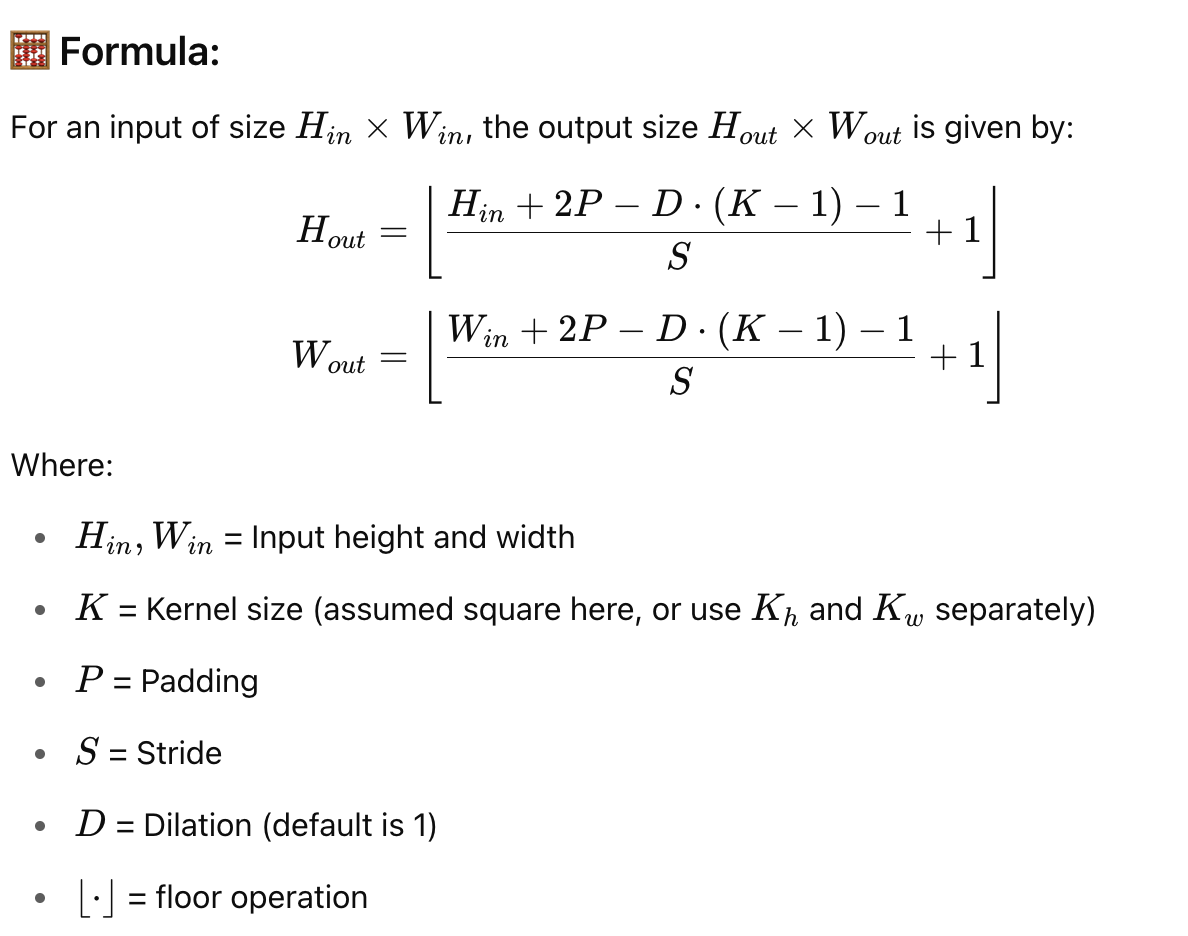

conv1 → relu → pool
conv2 → relu → pool
conv3 → relu
conv4 → relu
conv5 → relu → pool5

the 2 initial pool layers are a part of the alexnet structure

In [2]:
import torch.nn as nn
import torchvision.models as models

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.encoder = nn.Sequential(
        # layer 1
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # output: (96, 55, 55)
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # layer 2
        nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2),  # output: (256, 27, 27)
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # layer 3
        nn.Conv2d(256, 384, kernel_size=3, padding=1),           # output: (384, 13, 13)
        nn.ReLU(inplace=True),

        # layer 4
        nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2), # output: (384, 13, 13)
        nn.ReLU(inplace=True),

        # layer 5
        nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2), # output: (256, 13, 13)
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )

  def forward(self, x):
    return self.encoder(x)


In [3]:
# testing encoder

from PIL import Image, ImageDraw
import numpy as np
import pandas as pd

encoder = Encoder()

In [4]:
from PIL import Image
import torch
import numpy as np
from torchvision import transforms

# Load image
x = Image.open("/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/JPEGImages/2007_000027.jpg").convert('RGB')  # Ensure 3 channels

# Convert to float tensor and normalize to [0, 1]
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Required input size
    transforms.ToTensor(),          # Converts to float32 and scales to [0, 1]
])

x_tensor = transform(x).unsqueeze(0)  # Add batch dimension => (1, 3, 227, 227)
print(x_tensor.dtype)

# Now pass it to the model
output = encoder(x_tensor)

torch.float32


In [5]:
output.shape

torch.Size([1, 256, 6, 6])

### Channel Wise Fully Connected Layer

In [6]:
import torch
import torch.nn as nn

class ChannelWiseFC(nn.Module):
    def __init__(self, channels=256, spatial=6):
        super(ChannelWiseFC, self).__init__()
        # self.channels = channels
        # self.spatial = spatial
        # self.fc_layers = nn.ModuleList([
        #     nn.Linear(spatial * spatial, spatial * spatial) for _ in range(channels)
        # ])
        self.conv = nn.Conv2d(channels, channels, kernel_size=1, groups=channels) # to remove bottleneck, simulating fc behaviour

    # def forward(self, x):
    #     B, C, H, W = x.shape  # Expecting (B, 256, 6, 6)
    #     assert C == self.channels and H == self.spatial and W == self.spatial

    #     out = torch.zeros_like(x)

    #     for c in range(C):
    #         # Flatten (B, 6, 6) → (B, 36)
    #         xc = x[:, c, :, :].view(B, -1)
    #         xc_fc = self.fc_layers[c](xc)  # Taking out the layer for c'th channel then passing and getting output (B,36)
    #         out[:, c, :, :] = xc_fc.view(B, H, W)  # reshape back to (B, 6, 6)

    #     return out

    def forward(self, x):
        return self.conv(x)

In [7]:
channelFC = ChannelWiseFC()
fc_output = channelFC(output)

In [8]:
fc_output.shape

torch.Size([1, 256, 6, 6])

### Decoder

In [9]:
class Decoder(nn.Module):
  def __init__(self, channels = 256, spatial = 6):
    super(Decoder, self).__init__()

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 6 → 12
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 12 → 24
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 24 → 48
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # 48 → 96
        nn.ReLU(inplace=True),

        nn.Upsample(size=(227, 227), mode='bilinear', align_corners=False),
        nn.Conv2d(16, 3, kernel_size=3, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.decoder(x)

In [10]:
decoder = Decoder()
decoder_output = decoder(fc_output)

In [11]:
decoder_output.shape

torch.Size([1, 3, 227, 227])

## Context Encoder Compiled

In [12]:
class ContextEncoder(nn.Module):
  def __init__(self):
    super(ContextEncoder, self).__init__()

    self.encoder = Encoder()
    self.fc_channels = ChannelWiseFC()
    self.decoder = Decoder()

  def forward(self, x):
    x = self.encoder(x)
    x = self.fc_channels(x)
    x = self.decoder(x)
    return x

In [13]:
model = ContextEncoder()

In [14]:
model_out = model(x_tensor)

In [15]:
model_out.shape

torch.Size([1, 3, 227, 227])

## Loss Function

### Paper instructed

In [16]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(3, 227, 227)):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # -> [B, 64, 114, 114]
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> [B, 128, 57, 57]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )

        # Calculate flattened size automatically
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.features(dummy_input)
            self.flattened_dim = dummy_output.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [17]:
import torch
import torch.nn as nn

class ContextEncoderLoss(nn.Module):
    def __init__(self, lambda_rec=1.0, lambda_adv=0.001):
        super(ContextEncoderLoss, self).__init__()
        self.lambda_rec = lambda_rec
        self.lambda_adv = lambda_adv
        self.recon_loss = nn.MSELoss(reduction='sum')  # we'll normalize manually
        self.bce_loss = nn.BCELoss()

    def compute_reconstruction_loss(self, original, reconstructed, mask):
        """
        Masked L2 loss: applied only to the missing region.
        """
        masked_original = original * mask
        masked_reconstructed = reconstructed * mask
        norm = mask.sum() + 1e-8  # avoid division by zero
        loss = self.recon_loss(masked_reconstructed, masked_original) / norm
        return loss

    def compute_adversarial_loss(self, discriminator, real_imgs, fake_imgs):
        """
        Discriminator loss + Generator (ContextEncoder) adversarial loss.
        """
        real_labels = torch.ones(real_imgs.size(0), 1, device=real_imgs.device)
        fake_labels = torch.zeros(fake_imgs.size(0), 1, device=fake_imgs.device)

        # Discriminator Loss
        d_real = discriminator(real_imgs)
        d_fake = discriminator(fake_imgs.detach())
        d_loss = self.bce_loss(d_real, real_labels) + self.bce_loss(d_fake, fake_labels)

        # Generator (inpainting model) loss — wants D(fake) = 1
        g_loss = self.bce_loss(discriminator(fake_imgs), real_labels)

        return d_loss, g_loss

    def forward(self, original, reconstructed, mask, discriminator):
        L_rec = self.compute_reconstruction_loss(original, reconstructed, mask)
        D_loss, L_adv = self.compute_adversarial_loss(discriminator, original, reconstructed)
        L_total = self.lambda_rec * L_rec + self.lambda_adv * L_adv
        return L_total, L_rec, L_adv, D_loss

### L2 Reconstruction Only

In [18]:
# class ContextEncoderLoss(nn.Module):
#     def __init__(self):
#         super(ContextEncoderLoss, self).__init__()
#         self.recon_loss = nn.MSELoss(reduction='sum')  # we’ll normalize manually

#     def forward(self, original, reconstructed, mask):
#         masked_original = original * mask
#         masked_reconstructed = reconstructed * mask
#         norm = mask.sum() + 1e-8  # prevent divide-by-zero
#         loss = self.recon_loss(masked_reconstructed, masked_original) / norm
#         return loss

### L2 + Perceptual + Adversarial

In [19]:
# import torch.nn.functional as F
# from torchvision.models import vgg16
# import torchvision.transforms as T

# class PerceptualLoss(nn.Module):
#     def __init__(self, layers=[3, 8, 15], weight=1.0, device='mps'):
#         super().__init__()
#         self.weight = weight
#         self.vgg = vgg16(pretrained=True).features.to(device).eval()
#         for param in self.vgg.parameters():
#             param.requires_grad = False
#         self.selected_layers = layers
#         self.norm = T.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])


#     def forward(self, input, target):
#         # Normalize to VGG expected range
#         input = self.norm(input)
#         target = self.norm(target)

#         loss = 0.0
#         x = input
#         y = target
#         for i, layer in enumerate(self.vgg):
#             x = layer(x)
#             y = layer(y)
#             if i in self.selected_layers:
#                 loss += F.mse_loss(x, y)
#         return self.weight * loss

# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(3, 64, 4, 2, 1),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(64, 128, 4, 2, 1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2),
#             nn.Flatten(),
#             nn.Linear(128 * 56 * 56, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

# class ContextEncoderLossWithPerceptual(nn.Module):
#     def __init__(self, lambda_rec=1.0, lambda_adv=0.001, lambda_perc=0.01):
#         super().__init__()
#         self.lambda_rec = lambda_rec
#         self.lambda_adv = lambda_adv
#         self.lambda_perc = lambda_perc
#         self.recon_loss = nn.MSELoss(reduction='sum')
#         self.adv_loss = nn.BCELoss()
#         self.perc_loss = PerceptualLoss()

#     def forward(self, original, reconstructed, mask, discriminator):
#         # 1. Masked L2 loss
#         masked_original = original * mask
#         masked_pred = reconstructed * mask
#         norm = mask.sum() + 1e-8
#         L_rec = self.recon_loss(masked_pred, masked_original) / norm

#         # 2. Adversarial loss
#         real_labels = torch.ones(original.size(0), 1, device=original.device)
#         fake_labels = torch.zeros(original.size(0), 1, device=original.device)

#         d_real = discriminator(original)
#         d_fake = discriminator(reconstructed.detach())
#         D_loss = self.adv_loss(d_real, real_labels) + self.adv_loss(d_fake, fake_labels)
#         G_adv_loss = self.adv_loss(discriminator(reconstructed), real_labels)

#         # 3. Perceptual loss
#         L_perc = self.perc_loss(reconstructed, original)

#         # 4. Total loss
#         L_total = self.lambda_rec * L_rec + self.lambda_adv * G_adv_loss + self.lambda_perc * L_perc
#         return L_total, L_rec, L_perc, G_adv_loss, D_loss

### L2 + Adversarial Only

In [20]:
# class ContextEncoderLossWithAdversarialOnly(nn.Module):
#     def __init__(self, lambda_rec=1.0, lambda_adv=0.001):
#         super().__init__()
#         self.lambda_rec = lambda_rec
#         self.lambda_adv = lambda_adv
#         self.recon_loss = nn.MSELoss(reduction='sum')
#         self.adv_loss = nn.BCELoss()

#     def forward(self, original, reconstructed, mask, discriminator):
#         # 1. Masked L2 reconstruction loss
#         masked_original = original * mask
#         masked_pred = reconstructed * mask
#         norm = mask.sum() + 1e-8
#         L_rec = self.recon_loss(masked_pred, masked_original) / norm

#         # 2. Adversarial losses
#         real_labels = torch.ones(original.size(0), 1, device=original.device)
#         fake_labels = torch.zeros(original.size(0), 1, device=original.device)

#         d_real = discriminator(original)
#         d_fake = discriminator(reconstructed.detach())
#         D_loss = self.adv_loss(d_real, real_labels) + self.adv_loss(d_fake, fake_labels)

#         G_adv_loss = self.adv_loss(discriminator(reconstructed), real_labels)

#         # 3. Combined total loss
#         L_total = self.lambda_rec * L_rec + self.lambda_adv * G_adv_loss

#         return L_total, L_rec, G_adv_loss, D_loss

# Training Time 🪩🕺🏻

### dataset creation

In [21]:
from getData import getData
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torch

# transform for images
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

# Instantiate dataset and dataloader
dataset = getData(
    original_img_dir='/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/JPEGImages',
    masked_img_dir='/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_region_blocks',
    mask_suffix='_random_blocks',
    transform=transform
)

In [22]:
print(len(dataset))

17125


### dataset partition - train, test, batch

In [23]:
from torch.utils.data import random_split, DataLoader

# Define split ratio
train_ratio = 0.8
test_ratio = 0.2
total_size = len(dataset)

# Compute sizes
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 13700
Test samples: 3425


In [24]:
print(len(train_loader))

215


In [25]:
# loader is an iterable object that returns batches of data

for batch in loader:
    masked_imgs = batch['masked']      # Shape: [B, 3, 227, 227]
    original_imgs = batch['original']  # Shape: [B, 3, 227, 227]
    masks = batch['mask']              # Shape: [B, 1, 227, 227]
    names = batch['name']              # Shape: [B]
    break

NameError: name 'loader' is not defined

### training loop

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 1. Setup device
device = torch.device('mps')
print("Using device:", device)

# 2. Initialize model and move to GPU
# model = ContextEncoder().to(device)

# with updated loss functions
# Initialize model and discriminator
generator = ContextEncoder().to(device)
discriminator = Discriminator(input_shape=(3,227,227)).to(device)

# 3. Loss function (masked reconstruction only)
# loss_fn = ContextEncoderLoss()

# 3. # Loss function combining reconstruction, perceptual, adversarial
# loss_fn = ContextEncoderLossWithPerceptual(
#     lambda_rec=1.0, lambda_adv=0.001, lambda_perc=0.01
# )
# new loss function with only reconstrction (L2) and adversarial
loss_fn = ContextEncoderLoss(lambda_rec=1.0, lambda_adv=0.05)

# 4. Optimizer
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# updated
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# 5. Training loop
num_epochs = 50

for epoch in range(num_epochs):
    # model.train()
    # epoch_loss = 0.0
    generator.train()
    discriminator.train()
    epoch_loss = 0.0
    total_rec_loss = 0.0
    total_adv_loss = 0.0
    batch_iter = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        masked = batch['masked'].to(device)       # Input
        original = batch['original'].to(device)   # Target
        mask = batch['mask'].to(device)           # Binary mask

        # Forward
        # predicted = model(masked)
        # updated fwd
        predicted = generator(masked)

        # Compute reconstruction loss
        # loss = loss_fn(original, predicted, mask)
        # L_total, L_rec, L_perc, L_adv, D_loss = loss_fn(original, predicted, mask, discriminator) # updated loss fn with perceptual and adversarial loss
        L_total, L_rec, L_adv, D_loss = loss_fn(original, predicted, mask, discriminator) # loss with L2 and adversarial only

        # Backpropagation
        # updated backprop

        # Backprop for generator
        optimizer_G.zero_grad()
        L_total.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        optimizer_G.step()

        # Backprop for discriminator
        if batch_iter % 2 == 0:
            optimizer_D.zero_grad()
            D_loss.backward()
            optimizer_D.step()

        # epoch_loss += loss.item()
        epoch_loss += L_total.item()
        total_rec_loss += L_rec.item()
        total_adv_loss += L_adv.item()
        
        batch_iter += 1

    # print(f"Epoch {epoch+1} - Avg Loss: {epoch_loss / len(loader):.4f}")
    # print(f"Epoch {epoch+1}: Avg Loss = {epoch_loss / len(train_loader):.4f}")
    avg_total = epoch_loss / len(train_loader)
    avg_rec = total_rec_loss / len(train_loader)
    avg_adv = total_adv_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Total Loss: {avg_total:.4f} | Rec: {avg_rec:.4f} | Adv: {avg_adv:.6f}")

Using device: mps


Epoch 1/50: 100%|██████████| 215/215 [03:54<00:00,  1.09s/it]


Epoch 1 - Total Loss: 1.7730 | Rec: 0.3996 | Adv: 27.467364


Epoch 2/50: 100%|██████████| 215/215 [05:00<00:00,  1.40s/it]


Epoch 2 - Total Loss: 0.9033 | Rec: 0.3999 | Adv: 10.068996


Epoch 3/50: 100%|██████████| 215/215 [05:11<00:00,  1.45s/it]


Epoch 3 - Total Loss: 1.2679 | Rec: 0.3686 | Adv: 17.985580


Epoch 4/50: 100%|██████████| 215/215 [05:27<00:00,  1.52s/it]


Epoch 4 - Total Loss: 2.5778 | Rec: 0.2316 | Adv: 46.923285


Epoch 5/50: 100%|██████████| 215/215 [05:50<00:00,  1.63s/it]


Epoch 5 - Total Loss: 1.7919 | Rec: 0.2871 | Adv: 30.097045


Epoch 6/50: 100%|██████████| 215/215 [13:15<00:00,  3.70s/it]   


Epoch 6 - Total Loss: 0.8811 | Rec: 0.3498 | Adv: 10.627001


Epoch 7/50: 100%|██████████| 215/215 [04:25<00:00,  1.24s/it]


Epoch 7 - Total Loss: 0.6826 | Rec: 0.3390 | Adv: 6.872948


Epoch 8/50: 100%|██████████| 215/215 [05:08<00:00,  1.44s/it]


Epoch 8 - Total Loss: 0.5536 | Rec: 0.2844 | Adv: 5.383657


Epoch 9/50: 100%|██████████| 215/215 [05:12<00:00,  1.46s/it]


Epoch 9 - Total Loss: 0.3952 | Rec: 0.2191 | Adv: 3.521167


Epoch 10/50: 100%|██████████| 215/215 [05:04<00:00,  1.42s/it]


Epoch 10 - Total Loss: 0.3934 | Rec: 0.2153 | Adv: 3.562522


Epoch 11/50: 100%|██████████| 215/215 [13:11<00:00,  3.68s/it]   


Epoch 11 - Total Loss: 0.3830 | Rec: 0.2163 | Adv: 3.334996


Epoch 12/50: 100%|██████████| 215/215 [04:02<00:00,  1.13s/it]


Epoch 12 - Total Loss: 0.3888 | Rec: 0.2029 | Adv: 3.716982


Epoch 13/50: 100%|██████████| 215/215 [1:08:09<00:00, 19.02s/it]   


Epoch 13 - Total Loss: 0.4046 | Rec: 0.2122 | Adv: 3.847536


Epoch 14/50: 100%|██████████| 215/215 [1:11:10<00:00, 19.86s/it]   


Epoch 14 - Total Loss: 0.3686 | Rec: 0.1922 | Adv: 3.528353


Epoch 15/50: 100%|██████████| 215/215 [12:34<00:00,  3.51s/it]  


Epoch 15 - Total Loss: 0.3521 | Rec: 0.1919 | Adv: 3.203610


Epoch 16/50: 100%|██████████| 215/215 [05:03<00:00,  1.41s/it]


Epoch 16 - Total Loss: 0.3061 | Rec: 0.1811 | Adv: 2.499910


Epoch 17/50: 100%|██████████| 215/215 [05:44<00:00,  1.60s/it]


Epoch 17 - Total Loss: 0.3594 | Rec: 0.1979 | Adv: 3.228424


Epoch 18/50: 100%|██████████| 215/215 [05:57<00:00,  1.66s/it]


Epoch 18 - Total Loss: 0.2766 | Rec: 0.1669 | Adv: 2.193568


Epoch 19/50: 100%|██████████| 215/215 [06:05<00:00,  1.70s/it]


Epoch 19 - Total Loss: 0.3134 | Rec: 0.1738 | Adv: 2.792690


Epoch 20/50: 100%|██████████| 215/215 [06:09<00:00,  1.72s/it]


Epoch 20 - Total Loss: 0.4041 | Rec: 0.1918 | Adv: 4.246655


Epoch 21/50: 100%|██████████| 215/215 [06:14<00:00,  1.74s/it]


Epoch 21 - Total Loss: 0.4357 | Rec: 0.2067 | Adv: 4.580828


Epoch 22/50: 100%|██████████| 215/215 [06:16<00:00,  1.75s/it]


Epoch 22 - Total Loss: 0.3348 | Rec: 0.1740 | Adv: 3.216523


Epoch 23/50: 100%|██████████| 215/215 [06:16<00:00,  1.75s/it]


Epoch 23 - Total Loss: 0.4056 | Rec: 0.1886 | Adv: 4.339947


Epoch 24/50: 100%|██████████| 215/215 [06:17<00:00,  1.76s/it]


Epoch 24 - Total Loss: 0.3051 | Rec: 0.1632 | Adv: 2.839055


Epoch 25/50: 100%|██████████| 215/215 [09:38<00:00,  2.69s/it]  


Epoch 25 - Total Loss: 0.3014 | Rec: 0.1557 | Adv: 2.913491


Epoch 26/50: 100%|██████████| 215/215 [03:58<00:00,  1.11s/it]


Epoch 26 - Total Loss: 0.3259 | Rec: 0.1643 | Adv: 3.232526


Epoch 27/50: 100%|██████████| 215/215 [1:23:44<00:00, 23.37s/it]   


Epoch 27 - Total Loss: 0.3428 | Rec: 0.1674 | Adv: 3.506648


Epoch 28/50: 100%|██████████| 215/215 [34:58<00:00,  9.76s/it]   


Epoch 28 - Total Loss: 0.2974 | Rec: 0.1637 | Adv: 2.674186


Epoch 29/50: 100%|██████████| 215/215 [06:26<00:00,  1.80s/it]


Epoch 29 - Total Loss: 0.3314 | Rec: 0.1547 | Adv: 3.534470


Epoch 30/50: 100%|██████████| 215/215 [05:42<00:00,  1.59s/it]


Epoch 30 - Total Loss: 0.3186 | Rec: 0.1587 | Adv: 3.196296


Epoch 31/50: 100%|██████████| 215/215 [05:47<00:00,  1.62s/it]


Epoch 31 - Total Loss: 0.3670 | Rec: 0.1633 | Adv: 4.073487


Epoch 32/50: 100%|██████████| 215/215 [05:58<00:00,  1.67s/it]


Epoch 32 - Total Loss: 0.3852 | Rec: 0.1734 | Adv: 4.236434


Epoch 33/50: 100%|██████████| 215/215 [06:01<00:00,  1.68s/it]


Epoch 33 - Total Loss: 0.5018 | Rec: 0.2064 | Adv: 5.907482


Epoch 34/50: 100%|██████████| 215/215 [06:05<00:00,  1.70s/it]


Epoch 34 - Total Loss: 0.3428 | Rec: 0.1577 | Adv: 3.701848


Epoch 35/50: 100%|██████████| 215/215 [06:09<00:00,  1.72s/it]


Epoch 35 - Total Loss: 0.4473 | Rec: 0.1969 | Adv: 5.007920


Epoch 36/50: 100%|██████████| 215/215 [06:11<00:00,  1.73s/it]


Epoch 36 - Total Loss: 0.3811 | Rec: 0.1631 | Adv: 4.360490


Epoch 37/50: 100%|██████████| 215/215 [06:11<00:00,  1.73s/it]


Epoch 37 - Total Loss: 0.3462 | Rec: 0.1579 | Adv: 3.766112


Epoch 38/50: 100%|██████████| 215/215 [06:10<00:00,  1.72s/it]


Epoch 38 - Total Loss: 0.3864 | Rec: 0.1540 | Adv: 4.647787


Epoch 39/50: 100%|██████████| 215/215 [54:41<00:00, 15.26s/it]   


Epoch 39 - Total Loss: 0.3533 | Rec: 0.1527 | Adv: 4.010962


Epoch 40/50: 100%|██████████| 215/215 [04:22<00:00,  1.22s/it]


Epoch 40 - Total Loss: 0.3769 | Rec: 0.1537 | Adv: 4.464759


Epoch 41/50: 100%|██████████| 215/215 [05:18<00:00,  1.48s/it]


Epoch 41 - Total Loss: 0.4039 | Rec: 0.1555 | Adv: 4.967875


Epoch 42/50: 100%|██████████| 215/215 [39:38<00:00, 11.06s/it]   


Epoch 42 - Total Loss: 0.4375 | Rec: 0.1602 | Adv: 5.546324


Epoch 43/50: 100%|██████████| 215/215 [03:48<00:00,  1.06s/it]


Epoch 43 - Total Loss: 0.3631 | Rec: 0.1548 | Adv: 4.166266


Epoch 44/50: 100%|██████████| 215/215 [03:48<00:00,  1.06s/it]


Epoch 44 - Total Loss: 0.3854 | Rec: 0.1558 | Adv: 4.592748


Epoch 45/50: 100%|██████████| 215/215 [04:22<00:00,  1.22s/it]


Epoch 45 - Total Loss: 0.4079 | Rec: 0.1585 | Adv: 4.987103


Epoch 46/50: 100%|██████████| 215/215 [06:06<00:00,  1.70s/it] 


Epoch 46 - Total Loss: 0.4088 | Rec: 0.1589 | Adv: 4.997282


Epoch 47/50: 100%|██████████| 215/215 [04:43<00:00,  1.32s/it]


Epoch 47 - Total Loss: 0.4448 | Rec: 0.1674 | Adv: 5.547041


Epoch 48/50: 100%|██████████| 215/215 [10:50<00:00,  3.03s/it]  


Epoch 48 - Total Loss: 0.4809 | Rec: 0.1875 | Adv: 5.867314


Epoch 49/50: 100%|██████████| 215/215 [04:20<00:00,  1.21s/it]


Epoch 49 - Total Loss: 0.6680 | Rec: 0.2591 | Adv: 8.178336


Epoch 50/50: 100%|██████████| 215/215 [04:24<00:00,  1.23s/it]

Epoch 50 - Total Loss: 0.6073 | Rec: 0.2184 | Adv: 7.778253


In [28]:
model.eval()

ContextEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
      (9): ReLU(inplace=True)
      (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_channels): ChannelWiseFC(
    (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1,

In [29]:
import matplotlib.pyplot as plt
import torch

def show_inpainting_result(masked, predicted, original):
    masked = masked.permute(1, 2, 0).detach().cpu().numpy()
    predicted = predicted.permute(1, 2, 0).detach().cpu().numpy()
    original = original.permute(1, 2, 0).detach().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(masked)
    plt.title('Masked Input')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted)
    plt.title('Predicted (Inpainted)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original)
    plt.title('Original')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

torch.Size([3, 227, 227])


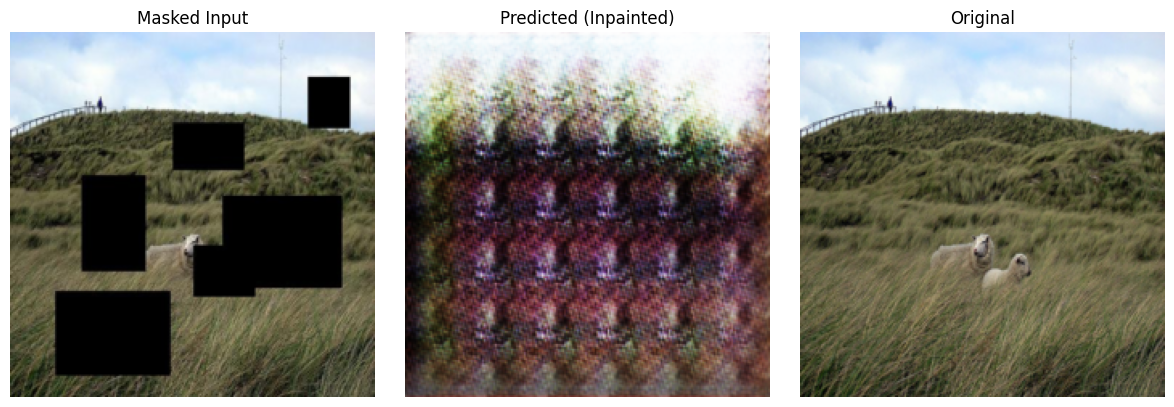

In [30]:
with torch.no_grad():
    for batch in test_loader:
        masked = batch['masked'].to(device)
        original = batch['original'].to(device)

        predicted = generator(masked)

        # Show the first sample in the batch
        print(original[0].shape)
        show_inpainting_result(masked[0], predicted[0], original[0])
        break  # remove break to loop over all batches